In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from balancers import PredictionBalancer
import tools

First, let's load our data. Here we're using some COVID outbreak investigation data with information about symptoms, test results, and demographics for each person.

In [2]:
records = pd.read_csv('records.csv')

Race will be our protected category. To keep things simple, we'll limit the category to 3 groups: `Black`, `White`, and `Undisclosed`.

In [3]:
race = records.race.values

Next, we'll set the true outcome variable, `Y`. This is the thing we're trying to predict fairly across groups. Since PCR is the gold standard for SARS-CoV2 infection, that's what we'll use here.

In [4]:
pcr = records.pcr.values

We also need to come up with some (potentially unfair) predictors to predict test status. We'll start with a few binary symptom variables, along with a compound case definition developed for a different oubtreak investigation.

In [5]:
cough = records.cough.values
fever = records.fever.values
taste = records.losstastesmell.values
case_def = records.case_def.values

predictors = [cough, fever, taste, case_def]
predictor_names = ['cough', 'fever', 'taste', 'case_def']

Before stratifying by race, let's start by seeing how well these predict test status overall. Since it takes class imbalance into account (and our outcome is pretty rare here), we'll use F1-score to measure the predictors' performance.

In [6]:
f1_scores = {predictor_names[i]:f1_score(pcr, p) for i, p in enumerate(predictors)}

In [7]:
f1_scores

{'cough': 0.32416787264833574,
 'fever': 0.3442940038684719,
 'taste': 0.3982494529540482,
 'case_def': 0.4083175803402646}

All 3 symptoms predict pretty well, but the case definition did the best, so let's go with that. To see whether it performs fairly across groups, we can fire up an instance of the `PredictionBalancer`, which will show us the definition's true positive rate (`tpr`) and false positive rate (`fpr`) for each group.

In [8]:
pb = PredictionBalancer(y=pcr, y_=fever, a=race)


Pre-adjustment group rates are 

                   group     fpr     tpr
Black / African American    0.04   0.125
             Undisclosed  0.0676  0.2838
                   White   0.044  0.3284

And loss is 0.1046



The error rate is only 10.5%, which is pretty good! We can see that there's some definite imbalance in performance between the groups, though, with sensitivity (`tpr`) for blacks being around than a third of what it is for whites. Let's use the `.adjust()` method to see if we can do any better.

In [9]:
pb.adjust()


Post-adjustment group rates are 

                   group     fpr     tpr
Black / African American    0.04   0.125
             Undisclosed  0.0367  0.1351
                   White  0.0427  0.0882

And loss is 0.1172



{'loss': 0.15828783552943404, 'roc': (0.04, 0.125)}

`.adjust()` returns the theoretical optima for loss (1 - accuracy, in this case) and the ROC coordinates after adjustment. With equalized odds, the best we can do for all groups is a FPR of 4% (very specific!) and TPR of 12.5% (not very sensitive).

By default, the adjuster also prints the ROC coordinates for the model's empirical predictions on the original dataset. Because of the sampling used to generate the predictions, these will often vary from the theoretical optima, but their long-run averages will be correct.

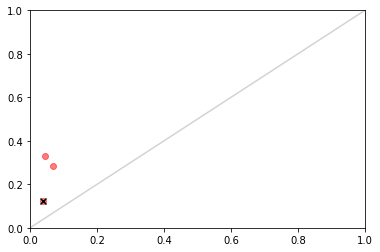

In [12]:
pb.plot()